# 神经网络是如何学习的？

通过一个简单的例子来理解：**让神经网络学会加法**。

## 为什么选择这个例子？

- **简单直观**：我们都知道 3 + 5 = 8
- **可以生成无限数据**：不需要下载数据集
- **容易验证**：网络学会了没有，一算便知
- **能看到本质**：神经网络如何表示数学运算？

## 目标

训练一个神经网络，输入两个数字（和小于 10），输出它们的和。

```
输入: [3, 5] → 神经网络 → 输出: 8
输入: [2, 4] → 神经网络 → 输出: 6
```

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from network import SimpleNN, train
from viz import (
    plot_training_history,
    plot_result_matrix,
    plot_hidden_activations,
    plot_forward_pass,
    plot_weights,
)

np.random.seed(42)

---

# 1. 数据表示

## 输入编码：One-Hot

神经网络把每个数字当作独立的「类别」，而不是连续的数值。

我们用 **one-hot 编码**：每个数字用 10 维向量表示，只有对应位置是 1。

```
0 → [1,0,0,0,0,0,0,0,0,0]
3 → [0,0,0,1,0,0,0,0,0,0]
9 → [0,0,0,0,0,0,0,0,0,1]
```

两个数字拼接成 20 维输入向量。

In [20]:
def one_hot(n, size=10):
    """数字转 one-hot 向量"""
    vec = np.zeros(size)
    vec[n] = 1
    return vec

def encode_input(a, b):
    """将两个数字编码为 20 维 one-hot 向量"""
    return np.concatenate([one_hot(a), one_hot(b)])

# 测试
x = encode_input(3, 5)
print(f"输入 (3, 5) 编码为 {len(x)} 维向量:")
print(f"  数字 a: {x[:10].astype(int)}  (位置 3 为 1)")
print(f"  数字 b: {x[10:].astype(int)}  (位置 5 为 1)")

输入 (3, 5) 编码为 20 维向量:
  数字 a: [0 0 0 1 0 0 0 0 0 0]  (位置 3 为 1)
  数字 b: [0 0 0 0 0 1 0 0 0 0]  (位置 5 为 1)


## 输出表示

限制加法结果小于 10，所以输出范围是 0-9，共 10 个类别。

我们把这当作**分类问题**：输出是 10 个类别的概率分布。

In [21]:
# 结果范围: 0 到 9
NUM_CLASSES = 10

def encode_output(result):
    """将结果编码为 one-hot"""
    return one_hot(result, NUM_CLASSES)

def decode_output(vec):
    """从 one-hot 解码为数字"""
    return np.argmax(vec)

# 测试
print(f"输出类别数: {NUM_CLASSES} (0 到 9)")
print(f"3 + 5 = 8 → {encode_output(8).astype(int)}")

输出类别数: 10 (0 到 9)
3 + 5 = 8 → [0 0 0 0 0 0 0 0 1 0]


---

# 2. 生成训练数据

我们枚举所有和小于 10 的加法组合：共 55 个样本。

```
(0,0), (0,1), ..., (0,9)  → 10 个
(1,0), (1,1), ..., (1,8)  → 9 个
...
(9,0)                     → 1 个
```

In [22]:
def generate_dataset():
    """生成所有和小于 10 的加法组合"""
    X, y = [], []
    
    for a in range(10):
        for b in range(10 - a):  # a + b < 10
            X.append(encode_input(a, b))
            y.append(encode_output(a + b))
    
    # 转换为 numpy 数组，(features, samples) 格式
    X = np.array(X).T
    y = np.array(y).T
    return X, y

X_all, y_all = generate_dataset()
print(f"数据集形状:")
print(f"  X: {X_all.shape}  (20 维输入 × {X_all.shape[1]} 样本)")
print(f"  y: {y_all.shape}  (10 维输出 × {y_all.shape[1]} 样本)")

数据集形状:
  X: (20, 55)  (20 维输入 × 55 样本)
  y: (10, 55)  (10 维输出 × 55 样本)


In [23]:
# 划分训练集和测试集
indices = np.random.permutation(X_all.shape[1])
X_shuffled = X_all[:, indices]
y_shuffled = y_all[:, indices]

# 80% 训练，20% 测试
split = int(0.8 * X_all.shape[1])
X_train, X_test = X_shuffled[:, :split], X_shuffled[:, split:]
y_train, y_test = y_shuffled[:, :split], y_shuffled[:, split:]

print(f"训练集: {X_train.shape[1]} 样本")
print(f"测试集: {X_test.shape[1]} 样本")

训练集: 44 样本
测试集: 11 样本


## 可视化数据分布

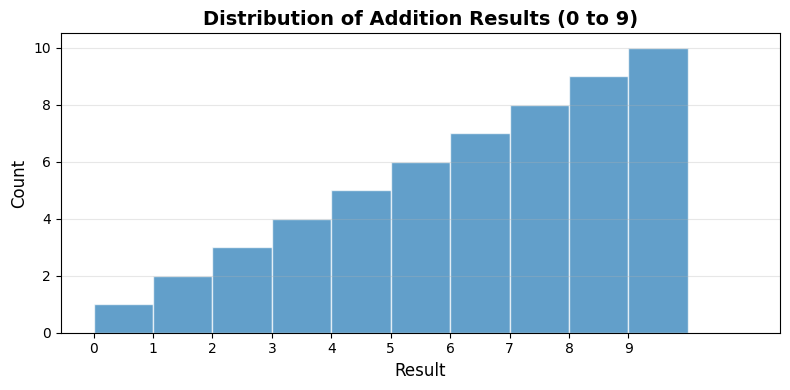

In [24]:
# 统计结果分布
results = [decode_output(y_all[:, i]) for i in range(y_all.shape[1])]

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(results, bins=range(0, 12), edgecolor='white', alpha=0.7)
ax.set_xlabel('Result', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Addition Results (0 to 9)', fontsize=14, fontweight='bold')
ax.set_xticks(range(0, 10))
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---

# 3. 构建神经网络

我们用一个简单的三层网络（定义在 `network.py`）：

```
输入层 (20) → 隐藏层 (16) → 隐藏层 (16) → 输出层 (10)
```

- 隐藏层用 ReLU 激活
- 输出层用 Softmax（分类问题）

In [25]:
# 创建网络（输入 20 维 one-hot）
model = SimpleNN([20, 16, 16, NUM_CLASSES])
print("网络结构: 20 → 16 → 16 → 10")
print(f"总参数量: {model.param_count()}")

网络结构: 20 → 16 → 16 → 10
总参数量: 778


---

# 4. 训练网络

观察网络如何从「什么都不会」到「学会计算」。

In [26]:
# One-hot 编码训练更快，可以用较大的学习率
print("开始训练...")
print("-" * 55)
history = train(model, X_train, y_train, X_test, y_test, epochs=500, lr=0.5)
print("-" * 55)
print(f"最终测试准确率: {history['test_acc'][-1]:.2%}")

开始训练...
-------------------------------------------------------
Epoch 100 | Loss: 0.2166 | Train: 100.00% | Test: 0.00%
Epoch 200 | Loss: 0.0269 | Train: 100.00% | Test: 0.00%
Epoch 300 | Loss: 0.0111 | Train: 100.00% | Test: 0.00%
Epoch 400 | Loss: 0.0065 | Train: 100.00% | Test: 0.00%
Epoch 500 | Loss: 0.0044 | Train: 100.00% | Test: 0.00%
-------------------------------------------------------
最终测试准确率: 0.00%


## 可视化学习过程

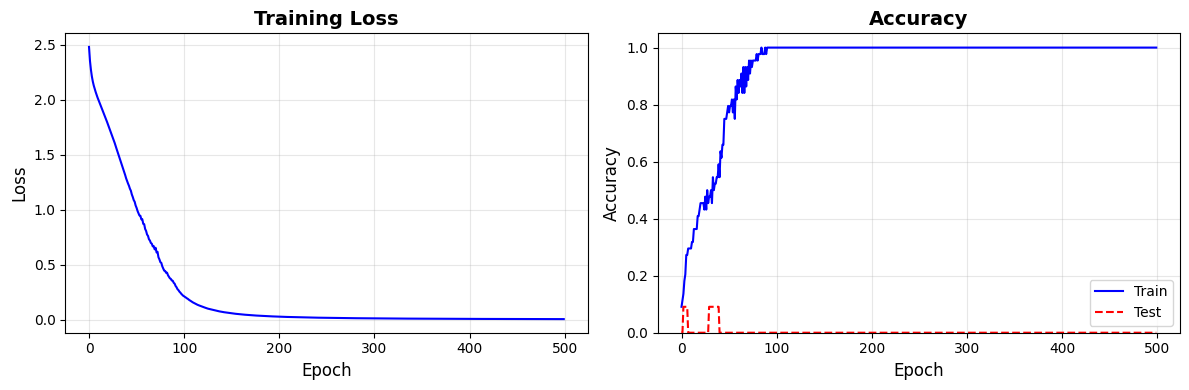

In [27]:
plot_training_history(history)

---

# 5. 测试网络

让我们来考考这个神经网络！

In [28]:
def test_calculation(model, a, b):
    """测试单个加法"""
    x = encode_input(a, b).reshape(-1, 1)
    pred = model.predict(x)[0]
    true = a + b
    status = "✓" if pred == true else "✗"
    print(f"{a} + {b} = {pred}  (正确答案: {true}) {status}")

print("=" * 40)
print("加法测试")
print("=" * 40)
for a, b in [(3, 5), (2, 4), (0, 9), (0, 0), (4, 5), (1, 7), (2, 2)]:
    test_calculation(model, a, b)

加法测试
3 + 5 = 8  (正确答案: 8) ✓
2 + 4 = 6  (正确答案: 6) ✓
0 + 9 = 9  (正确答案: 9) ✓
0 + 0 = 0  (正确答案: 0) ✓
4 + 5 = 9  (正确答案: 9) ✓
1 + 7 = 8  (正确答案: 8) ✓
2 + 2 = 4  (正确答案: 4) ✓


## 完整的加法测试矩阵

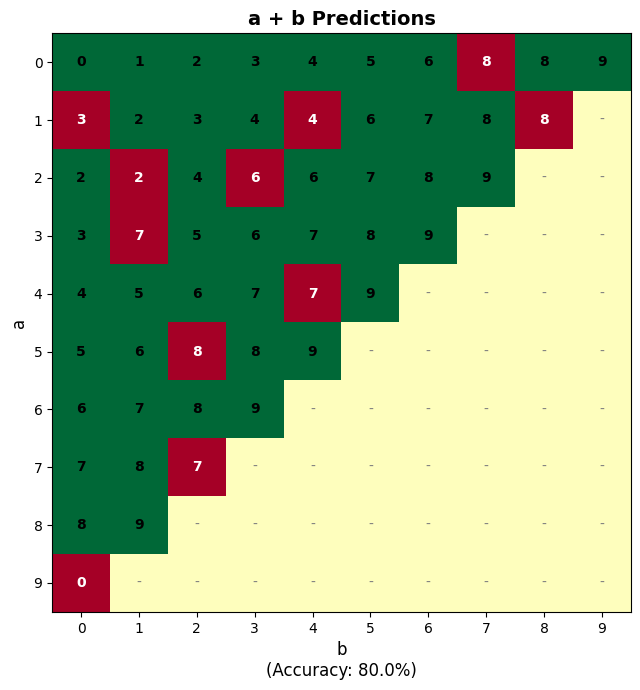

np.float64(0.8)

In [29]:
plot_result_matrix(model, encode_input, max_sum=10)

---

# 6. 洞察：神经网络学到了什么？

网络内部发生了什么？让我们来探索。

## 隐藏层激活可视化

我们可以观察不同输入时隐藏层神经元的激活模式。

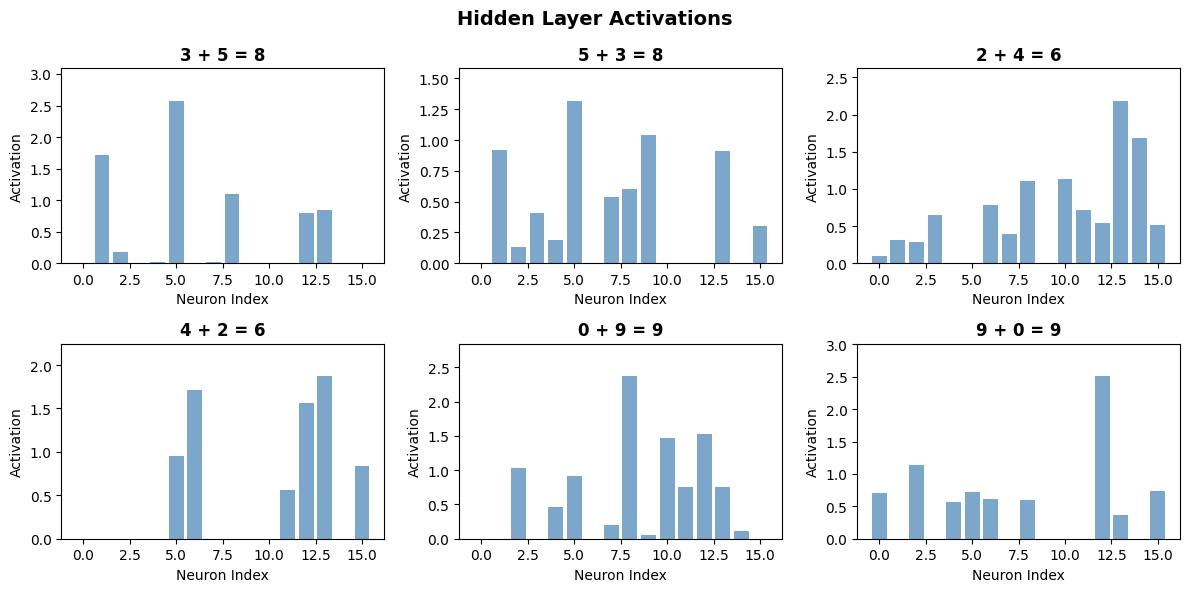

In [30]:
test_cases = [
    (3, 5), (5, 3),  # 交换律：3+5 和 5+3
    (2, 4), (4, 2),  # 交换律：2+4 和 4+2
    (0, 9), (9, 0),  # 边界情况
]
plot_hidden_activations(model, encode_input, test_cases)

## 前向传播可视化：数据如何流过网络

让我们追踪一个具体输入如何「穿过」网络的每一层。

下图展示了网络结构，每个圆圈代表一个神经元：
- **颜色深浅**：表示激活值大小（越深 = 激活越强）
- **输入层**：显示输入的数字
- **隐藏层**：显示每个神经元的激活值
- **输出层**：金色高亮的是预测结果

这就是**前向传播**的本质：数据逐层变换，最终得到预测。

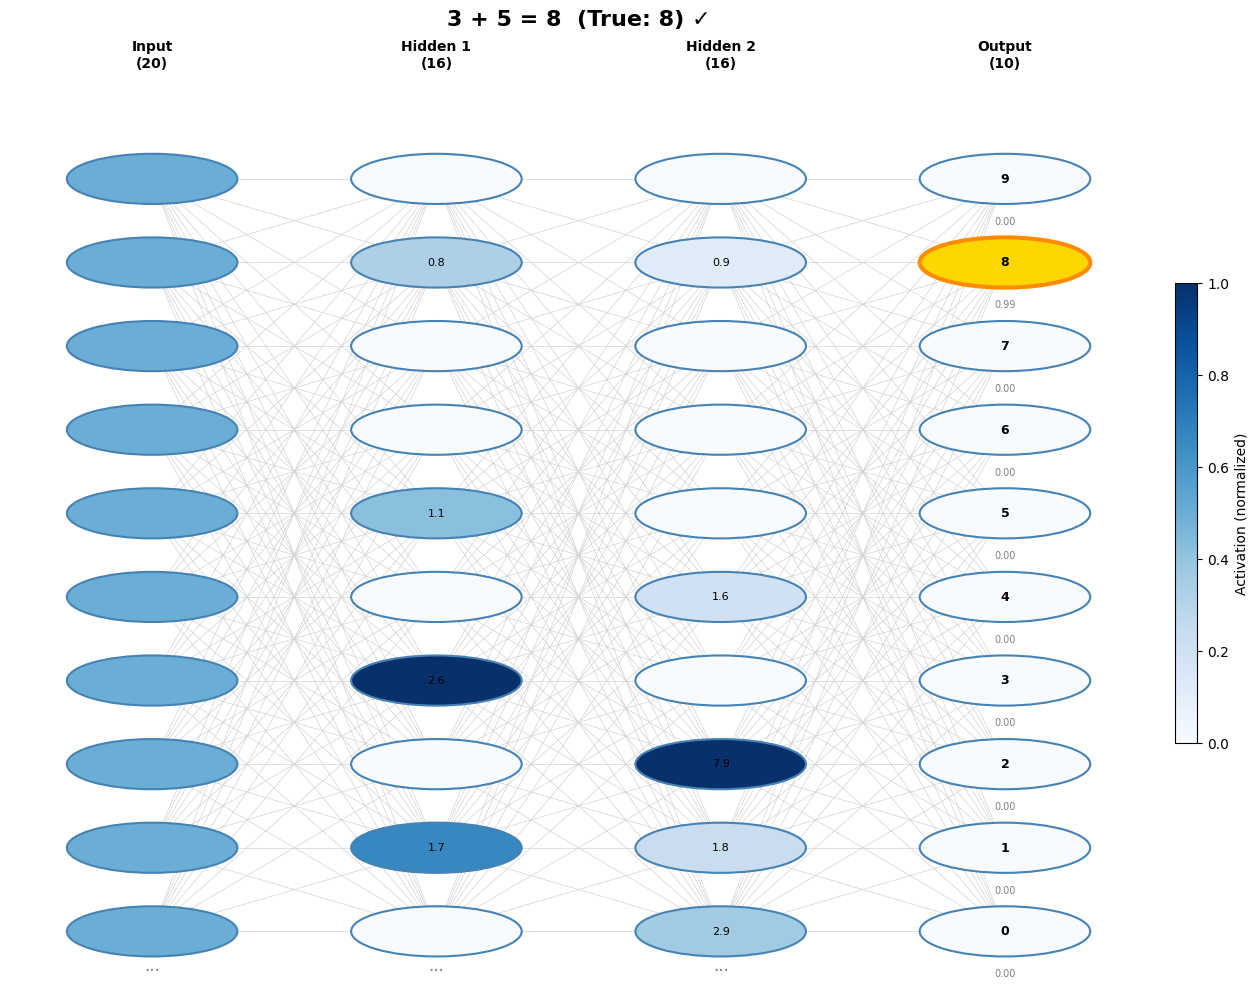


输入: 3 + 5
预测: 8  |  正确答案: 8  |  ✓ 正确

Layer 1: 16 neurons
  activation: min=0.000, max=2.574, mean=0.453

Layer 2: 16 neurons
  activation: min=0.000, max=7.886, mean=1.021

Layer 3: 10 neurons
  activation: min=0.000, max=0.994, mean=0.100
  Top 3: [(np.int64(8), '0.994'), (np.int64(9), '0.002'), (np.int64(5), '0.002')]


In [31]:
# 加法例子: 3 + 5 = 8
plot_forward_pass(model, 3, 5, encode_input)

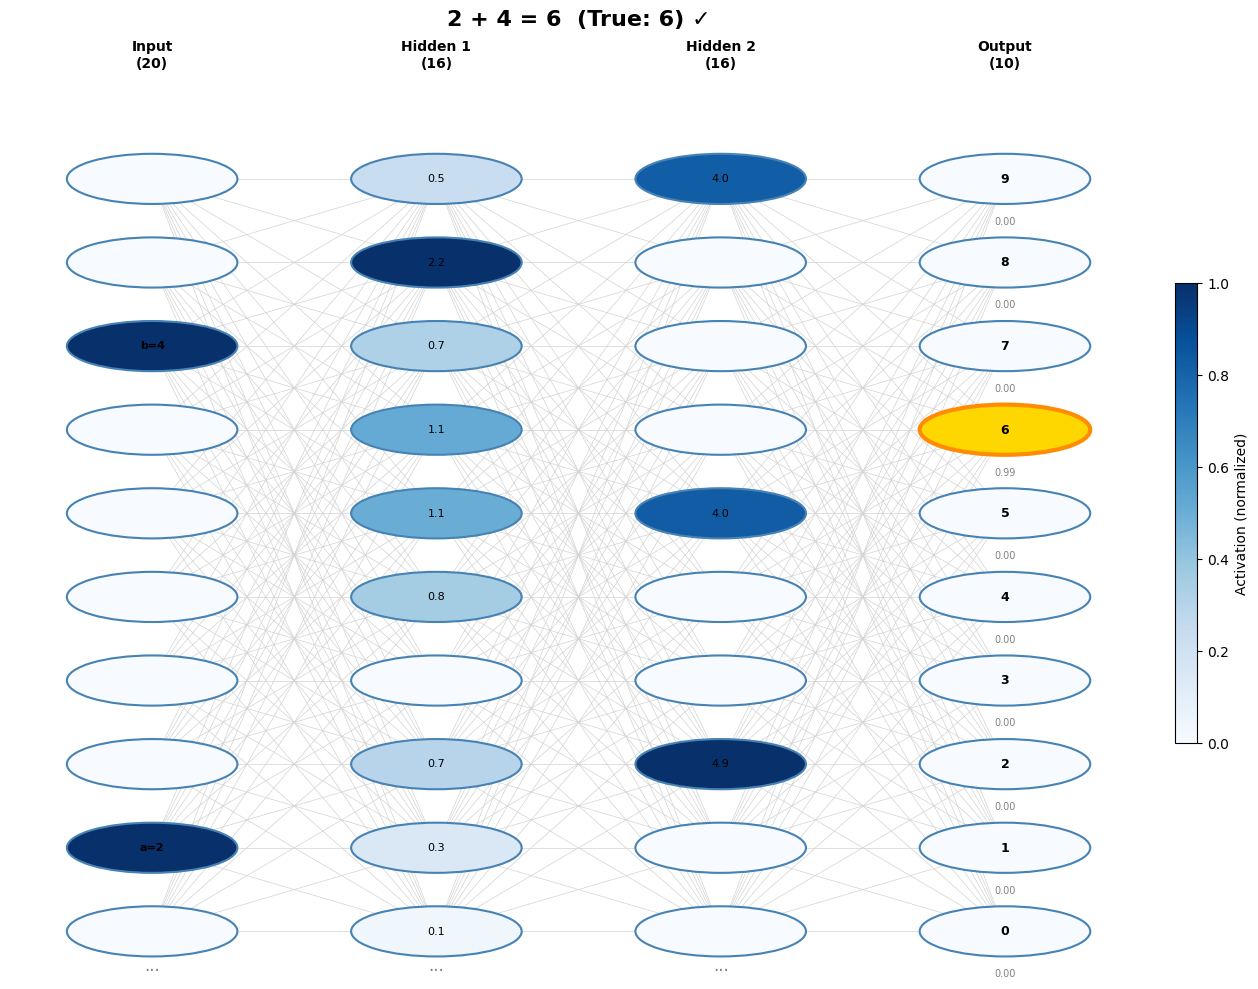


输入: 2 + 4
预测: 6  |  正确答案: 6  |  ✓ 正确

Layer 1: 16 neurons
  activation: min=0.000, max=2.184, mean=0.649

Layer 2: 16 neurons
  activation: min=0.000, max=6.219, mean=1.518

Layer 3: 10 neurons
  activation: min=0.000, max=0.994, mean=0.100
  Top 3: [(np.int64(6), '0.994'), (np.int64(7), '0.004'), (np.int64(4), '0.002')]


In [32]:
# 另一个例子: 2 + 4 = 6
plot_forward_pass(model, 2, 4, encode_input)

### 观察要点

从上面的可视化中，我们可以观察到：

1. **输入层**：20 个神经元（one-hot 编码），只有 2 个被激活（显示 a=? 和 b=?）
2. **隐藏层**：神经元颜色深浅反映激活强度，数字显示激活值
3. **输出层**：10 个神经元对应 10 个可能的结果（0-9），金色高亮的是预测结果
4. **连接线**：每层的每个神经元都与下一层的所有神经元相连（全连接）

**关键理解**：
- One-hot 编码让每个数字成为独立的「开关」
- 激活值为 0 的神经元（浅色）被 ReLU「关闭」了
- 最终预测取决于输出层哪个神经元激活最强

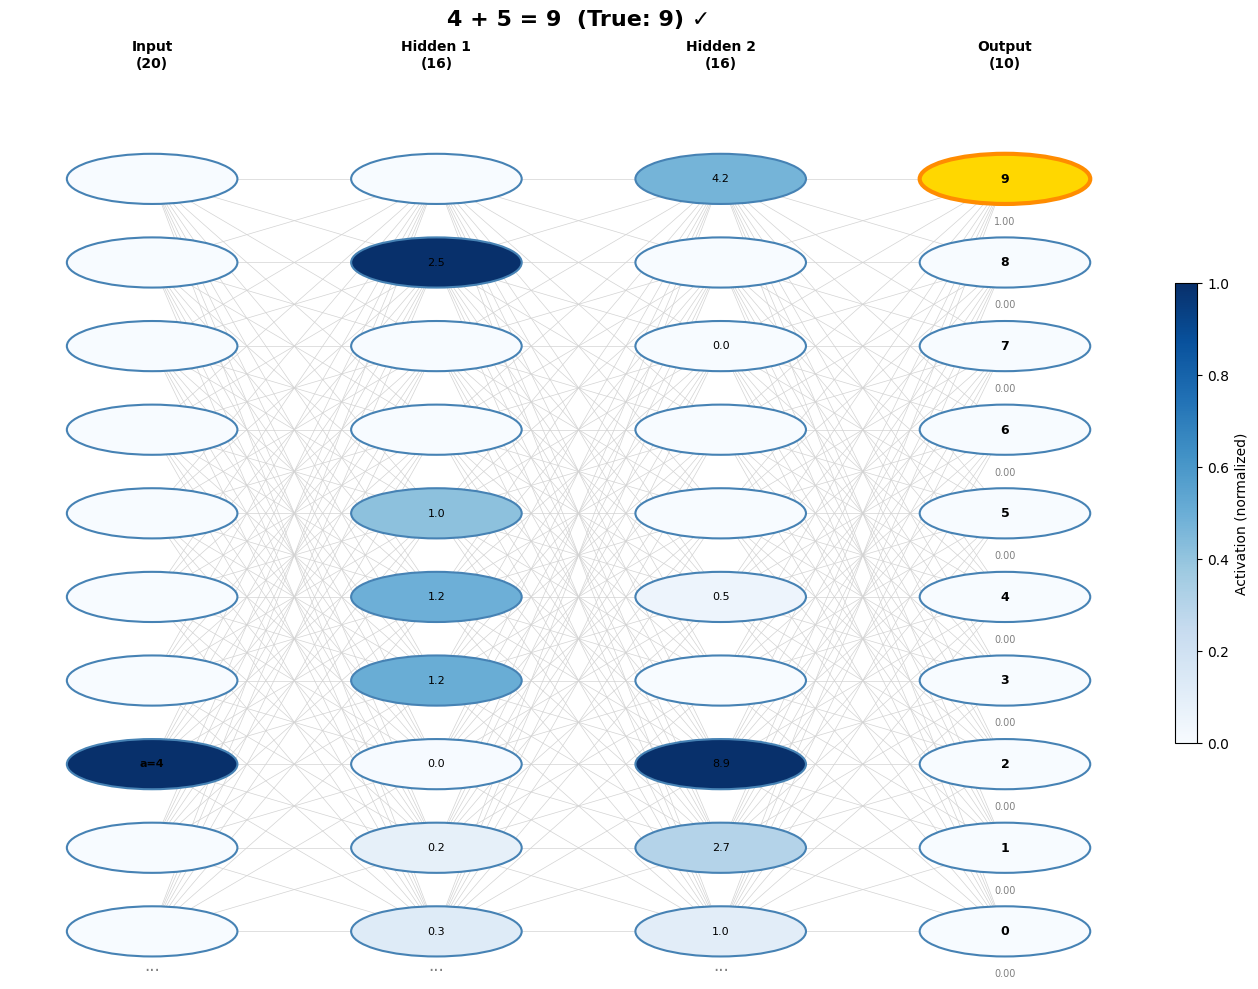


输入: 4 + 5
预测: 9  |  正确答案: 9  |  ✓ 正确

Layer 1: 16 neurons
  activation: min=0.000, max=2.465, mean=0.451

Layer 2: 16 neurons
  activation: min=0.000, max=8.944, mean=1.263

Layer 3: 10 neurons
  activation: min=0.000, max=0.998, mean=0.100
  Top 3: [(np.int64(9), '0.998'), (np.int64(7), '0.002'), (np.int64(6), '0.000')]


In [33]:
# 边界情况: 4 + 5 = 9
plot_forward_pass(model, 4, 5, encode_input)

### 自己试试

修改下面的参数来观察不同输入的前向传播过程：

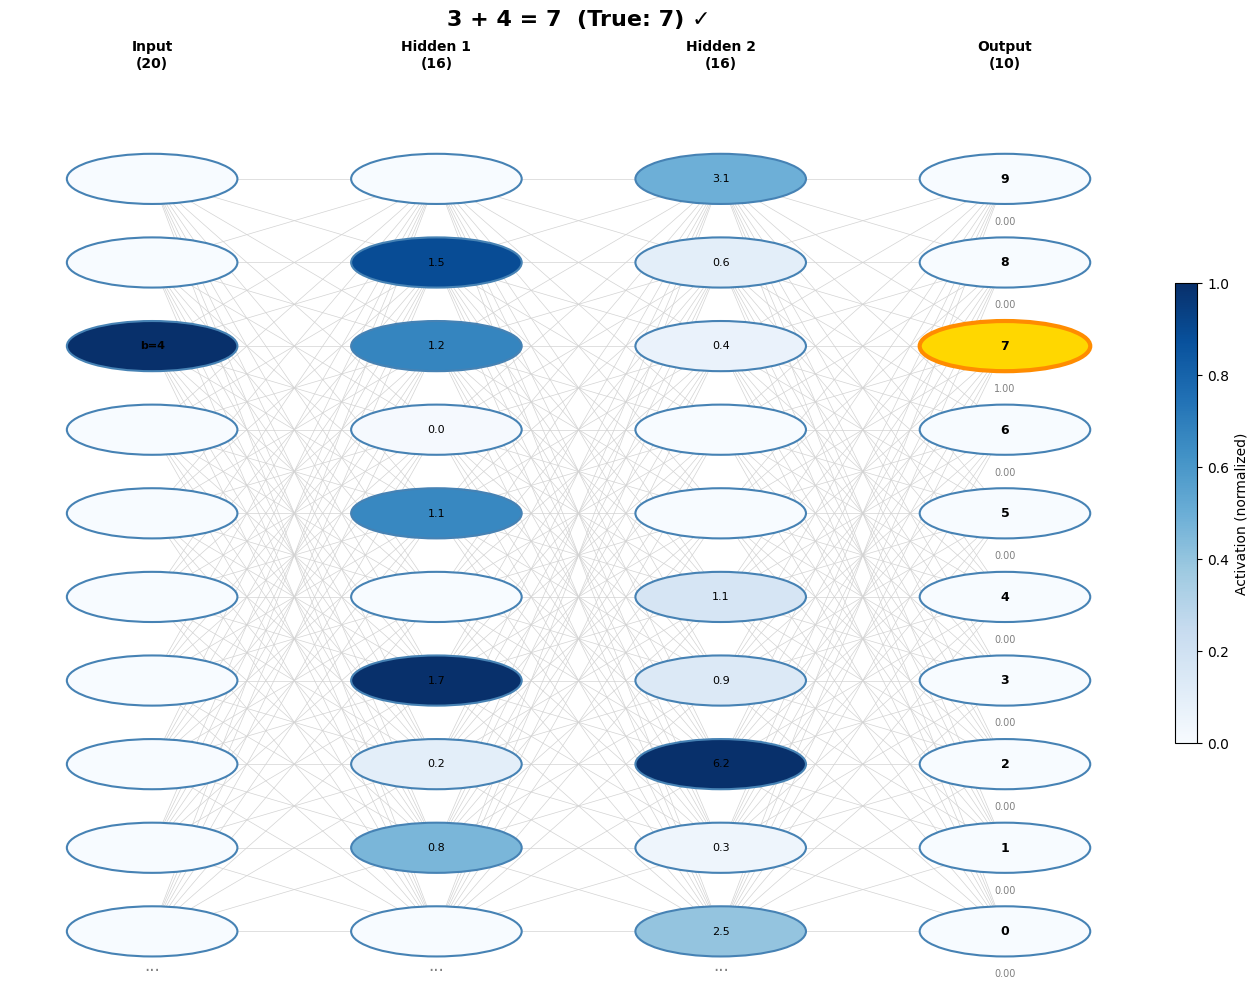


输入: 3 + 4
预测: 7  |  正确答案: 7  |  ✓ 正确

Layer 1: 16 neurons
  activation: min=0.000, max=1.718, mean=0.614

Layer 2: 16 neurons
  activation: min=0.000, max=6.162, mean=1.238

Layer 3: 10 neurons
  activation: min=0.000, max=0.997, mean=0.100
  Top 3: [(np.int64(7), '0.997'), (np.int64(9), '0.001'), (np.int64(8), '0.001')]


In [34]:
# 修改这两个变量来探索不同的输入（确保 a + b < 10）
a_input = 3
b_input = 4

plot_forward_pass(model, a_input, b_input, encode_input)

---

# 7. 总结与思考

## 我们做了什么？

1. **把加法问题转换为分类问题**：输入 2 个数字 → 输出 10 类（0-9）
2. **用 55 个样本训练网络**：覆盖所有和小于 10 的加法组合
3. **网络成功学会了计算**：准确率接近 100%

## 神经网络真的「理解」加法吗？

**不完全是**。神经网络学到的是输入模式到输出模式的映射，而不是抽象的数学规则。

**证据**：如果我们测试 5 + 6 = 11，网络会失败，因为它没见过和大于 9 的情况。

## 这告诉我们什么？

1. **神经网络是强大的函数逼近器**：能学习任意输入输出映射
2. **泛化有边界**：只能在训练数据的「邻域」内泛化
3. **数据决定能力**：网络只能学会训练数据中包含的模式

## 思考题

1. 如果扩展到和小于 100，需要多少训练样本？
2. 网络能学会乘法吗？为什么乘法可能更难？
3. 如果把输出改成回归（直接输出数值），效果会怎样？

In [35]:
# 实验：测试网络在训练范围外的表现
print("测试训练范围外的输入（和 >= 10）:")
print("-" * 40)
for a, b in [(5, 5), (6, 6), (9, 9)]:
    x = encode_input(a, b).reshape(-1, 1)
    pred = model.predict(x)[0]
    true = a + b
    print(f"{a} + {b} = {pred}  (正确答案: {true}) ✗")

print("\n网络无法泛化到训练数据范围之外！")

测试训练范围外的输入（和 >= 10）:
----------------------------------------
5 + 5 = 9  (正确答案: 10) ✗
6 + 6 = 9  (正确答案: 12) ✗
9 + 9 = 9  (正确答案: 18) ✗

网络无法泛化到训练数据范围之外！


---

## 扩展阅读

想深入了解神经网络的数学原理？请看 [neural_networks.ipynb](neural_networks.ipynb)。